# Introduction into Data Science - Assignment Part II

This is the second part of the assignment in IDS 2023/2024.

This part of the assignment consists of five questions — each of these questions is contained in a separate Jupyter notebook:
- [Question 1: Data Preprocessing](Q1_Preprocessing_Visualization.ipynb)
- [Question 2: Association Rules](Q2_Frequent_Itemsets_Association_Rules.ipynb)
- [Question 3: Process Mining](Q3_Process_Mining.ipynb)
- [Question 4: Text Mining](Q4_Text_Mining.ipynb)
- [Question 5: Big Data](Q5_Big_Data.ipynb)

Additional required files are in two folders.
- [datasets](datasets/)
- [scripts](scripts/)

Please use the provided notebook to work on the questions. When you are done, upload your version of each of the notebooks to Moodle. Your submission will, therefore, consist of five jupyter notebook and _no_ additional file. Any additionally provided files will not be considered in grading.
Enter your commented Python code and answers in the corresponding cells. Make sure to answer all questions in a clear and explicit manner and discuss your outputs. _Please do not change the general structure of this notebook_. You can, however, add additional markdown or code cells if necessary. Please **DO NOT CLEAR THE OUTPUT** of the notebook you are submitting! Additionally, please ensure that the code in the notebook runs if placed in the same folder as all of the provided files, delivering the same outputs as the ones you submit in the notebook. This includes being runnable in the bundled conda environment.

*Please make sure to include the names and matriculation numbers of all group members in the provided slots in each of the notebooks.* If a name or a student id is missing, the student will not receive any points.

Hint 1: **Plan your time wisely.** A few parts of this assignment may take some time to run. It might be necessary to consider time management when you plan your group work. Also, do not attempt to upload your assignment at the last minute before the deadline. This often does not work, and you will miss the deadline. Late submissions will not be considered.

Hint 2: RWTHMoodle allows multiple submissions, with every new submission overwriting the previous one. **Partial submissions are possible and encouraged.** This might be helpful in case of technical issues with RWTHMoodle, which may occur close to the deadline.

Hint 3: As a technical note. Some IDEs such as DataSpell may automatically strip jupyter notebook cell metadata. If you are able, please re-add it from the source notebooks before submission. This is necessary for our grading.

Enter your group number and members with matriculation numbers below.

In [1]:
GROUP_NO = 112 # group number
GROUP_MEMBERS = {
    451963: "Paul Väthjunker", # mat. no. : name,
    413004: "Touyen Nguyenova",
}


---

In [2]:
# required imports
# do not edit!

import nltk
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import unicodedata
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
snow_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer();

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\metoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\metoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\metoo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\metoo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Question 4: Text Mining (23 pts)


## About the Data: Taylor Swift

In this task, our data consists of song lyrics from nine albums by Taylor Swift. Taylor Swift is one of the best-selling musicians and currently subject of various research. As she is known to venture into different musical genres and make artistic innovations for each album, we want to check whether we can support this claim using Text Mining.

Therefore, we:
1. Load the data and preprocess it first,
2. use the set of words for recognizing a lyric's album,
3. use Doc2Vec to check the similarity of albums and to cluster them,
4. and finally use language models that are based on n-grams to generate some own lyrics.

We aim to support our data analysis by reporting data and discussing results. 

## Data Loading and Preprocessing (8 Pts)

### a)
i. First things first. Import the file **q4_taylor_swift.csv** and save it into a dataframe named `swift_df`. Visualize the dataframe by showing the first five lines. 

_Note: In this question, every lyric is considered as a single document. The data contains lyrics from several albums. The order of the lyrics is preserved considering their album, song and within their song._


In [3]:
# Import and visualization.
swift_df = pd.read_csv("datasets\q4_taylor_swift.csv")
print(swift_df.head())

          album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck


ii. As a first step in preprocessing, normalize all unicode encodings using `unicodedata.normalize` with 'NKFD' as the form and remove all closing and opening brackets, i.e., '(' and ')'.

In [4]:
entries_bracket = swift_df[swift_df['lyric'].str.contains(r'\(')]

def preprocess_text(text):
    normalized_text = unicodedata.normalize('NFKD', text)
    processed_text = normalized_text.replace('(', '').replace(')', '')
    return processed_text

swift_df['lyric'] = swift_df['lyric'].apply(preprocess_text)
swift_df['album'] = swift_df['album'].apply(preprocess_text)


print(swift_df.head())

          album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck


In [5]:
print(entries_bracket.head())
# print(entries_bracket.index.to_list())
print(swift_df.iloc[entries_bracket.index.tolist()[:5]])

                           album  \
327                 Taylor Swift   
342                 Taylor Swift   
356                 Taylor Swift   
782  Fearless (Taylor’s Version)   
922  Fearless (Taylor’s Version)   

                                               lyric  
327                 Get back to me (get back to me).  
342                 Get back to me (get back to me).  
356                 Get back to me (get back to me).  
782  But would they write a song for you? (Ha-ha-ha)  
922                       I'm sorry, I'm sorry (Mmm)  
                         album                                          lyric
327               Taylor Swift                 Get back to me get back to me.
342               Taylor Swift                 Get back to me get back to me.
356               Taylor Swift                 Get back to me get back to me.
782  Fearless Taylor’s Version  But would they write a song for you? Ha-ha-ha
922  Fearless Taylor’s Version                       I'm sorry,

### b)
We get a first idea of the data distribution over the albums by counting the lyrics in our data per album. Code the method `count_lyrics_per_album`.

In [6]:
def count_lyrics_per_album(input_df: pd.DataFrame) -> pd.Series:
    """ 
    Counts the lyrics for each album and stores them in a pandas series.
    :param input_df: A pandas dataframe containing album data and their lyrics.
    :return: The data containing the albums and the count of lyrics per album.
    """
    word_counts = input_df.groupby('album')['lyric'].apply(lambda x: x.str.split().apply(len).sum())
    # print(word_counts)
    return word_counts

In [7]:
# Using the predefined function to calculate the series of values
count_per_album = count_lyrics_per_album(swift_df)

# Transforming the series to a dataframe for visualization - feel free to check the series object
pd.DataFrame({'album': count_per_album.index, 'lyric count': count_per_album.values})

,album,lyric count
0,1989 Deluxe,7159
1,Fearless Taylor’s Version,8809
2,Lover,6745
3,Red Deluxe Edition,7290
4,Speak Now Deluxe,6781
5,Taylor Swift,4286
6,evermore deluxe version,5982
7,folklore deluxe version,5124
8,reputation,7209


### c)
i. Next, we visualize the counted lyrics per album using a barplot. Write down your code in `plot_lyric_count`.

In [8]:
def plot_lyric_count(input_series: pd.Series):
    """ 
    Visualizes the number of lyrics for each album in a bar plot.
    :param input_series: A pandas series containing album data and their lyric counts.
    """
    input_series.plot(kind='bar', color='skyblue')
    mpl.pyplot.title('Number of Lyrics per Album')
    mpl.pyplot.xlabel('Album')
    mpl.pyplot.ylabel('Lyric Count')
    mpl.pyplot.xticks(rotation=45, ha='right')
    mpl.pyplot.tight_layout()
    mpl.pyplot.show()


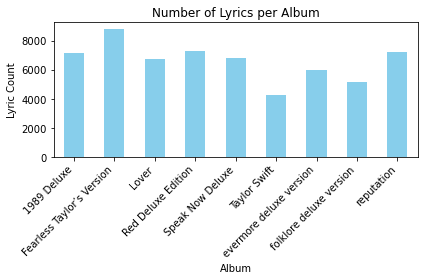

In [9]:
# Visualizing the data of 'count_per_album' as a bar plot using your function
plot_lyric_count(count_per_album)

ii. Is the data balanced enough for album classification?

__Student Answer:__ Given the visualization, there are discrepancies between the highest and lowest lyric count - Fearless Taylor's Version (8809) and Taylor Swift (4286), the prior album may entail twice the amount of lyrics than the latter album, but it is still not extreme. As for the rest of the albums, the disparities are less. One could argue that the dataset is marginally balanced enough with both min and max as outliers. 

### d)
In the following, we want to remove duplicate lyrics, as a song may contain a lyric more than once. Removing duplicates improves the interpretability of the further analysis and reduces an overfitting of the classification task on the duplicated lyrics. 

i. Therefore, as a first step, we remove all duplicate lyrics and keep only a single instance per duplicate lyric on each album. The obtained dataset has to be named `swift_df_proc`.

In [10]:
# Dropping all duplicates of a lyric on an album
print(swift_df.shape)
swift_df_proc = swift_df.drop_duplicates(subset=['album', 'lyric'])
print(swift_df_proc.shape)

(8329, 2)
(5559, 2)


          album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck


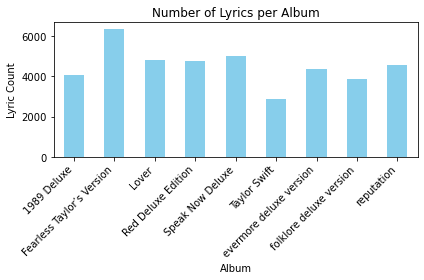

In [11]:
print(swift_df_proc.head())
plot_lyric_count(count_lyrics_per_album(swift_df_proc))

ii. Do lyrics occur in several albums? If this is the case, remove them entirely as such a lyric is not suitable for our further questions. If this is not the case, give the code that shows so. Remember also to give a clear answer below. 

In [12]:
lyric_album_counts = swift_df_proc.groupby('lyric')['album'].nunique()
lyrics_multiple_albums = lyric_album_counts[lyric_album_counts > 1]

if not lyrics_multiple_albums.empty:
    swift_df_proc = swift_df_proc[~swift_df_proc['lyric'].isin(lyrics_multiple_albums.index)]
    print("Lyrics occur in several albums. Removed them entirely from the dataset.")
else:
    print("Lyrics do not occur in several albums.")

# Print the dimensions of the updated dataset
print("Dimensions of the updated dataset:", swift_df_proc.shape)


Lyrics occur in several albums. Removed them entirely from the dataset.
Dimensions of the updated dataset: (5526, 2)


__Student Answer:__ Some identical lyrics do occur in various albums, though not many. 

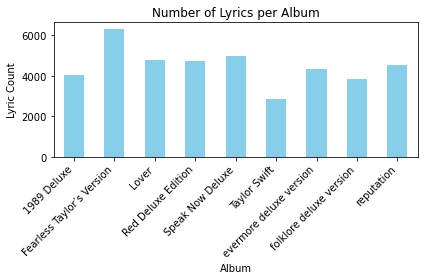

album
1989 Deluxe                  4043
Fearless Taylor’s Version    6324
Lover                        4800
Red Deluxe Edition           4716
Speak Now Deluxe             4975
Taylor Swift                 2860
evermore deluxe version      4339
folklore deluxe version      3863
reputation                   4560
Name: lyric, dtype: int64

In [13]:
plot_lyric_count(count_lyrics_per_album(swift_df_proc))
count_lyrics_per_album(swift_df_proc)

### e)
The following tasks are more related to the preprocessing that has to be applied for the Text Mining context. First of all, we have to create a corpus. The obtained corpus should be named `corpus`. Make sure that each document in the corpus corresponds to exactly one lyric in `swift_df_proc`. 

In [14]:
# Creating the corpus

# corpus = [reg_tokenizer.tokenize(lyric.lower()) for lyric in swift_df_proc['lyric']]
# corpus = [word for lyric_words in corpus for word in lyric_words]

corpus = swift_df_proc['lyric'].tolist()

corpus[:5]

['He said the way my blue eyes shined',
 'Put those Georgia stars to shame that night',
 'I said, "That\'s a lie"',
 'Just a boy in a Chevy truck',
 "That had a tendency of gettin' stuck"]

### f)
Use the skeleton of the function `preprocessor_func` below to create a function that applies tokenization, stopword removal and lemmatization to an input string. The remaining tokens (after stopword removal and lemmatization) should be joined using a whitespace (' ').

_Note: To keep the complexity low, we do not expect you to use POS tagging before lemmatizing. You can apply lemmatization only for the nouns. This is covered by using a lemmatizer without further arguments._

In [15]:
def preprocessor_func(text: str) -> str:
    """
    Preprocesses a string using tokenization, stopword removal and lemmatization.
    :param text: A string to be preprocessed.
    :return: A joined string resulting from tokenization, stopword removal and lemmatization of an input string.
    """
    tokens = reg_tokenizer.tokenize(text.lower())
    tokens = [word for word in tokens if word not in stopword_list]
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(word, pos='n') for word in tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

### g)
Now, create a preprocessed corpus `corpus_proc` by applying the preprocessing function to your corpus. For some tasks, we have to use the preprocessed corpus, and for some, the original corpus. This is indicated for each task.

In [16]:
# Corpus preprocessing
corpus_proc = [preprocessor_func(lyric) for lyric in corpus]
corpus_proc[:5]

['said way blue eye shined',
 'put georgia star shame night',
 'said lie',
 'boy chevy truck',
 'tendency gettin stuck']

### h)
In this task, we create all preprocessed data for all remaining tasks within the Text Mining question exercise.
For the later application of the set of words, we need to split the corpus.
First, we need to split our input data into a train and test set according to the Pareto rule (80% training set size and 20% test set size).
Therefore, split the dataframe `swift_df_proc` into a training and test set using the variable identifiers `df_train`, `df_test`, `y_train`, and `y_test`.
Further, make sure that distribution based on the "album" value is preserved.

In [17]:
X = swift_df_proc['lyric']
y = swift_df_proc['album']

df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set size:", len(df_train))
print("Test set size:", len(df_test))

Training set size: 4420
Test set size: 1106


### i)
Lastly, we create two further corpora, `corpus_train` and `corpus_test`, using the split data and the identical approach that is used before.

In [18]:
corpus_train = [preprocessor_func(lyric) for lyric in df_train]
corpus_test = [preprocessor_func(lyric) for lyric in df_test]

print(corpus_train[:5])
print(corpus_test[:5])

['everything need right side', 'meet spirit meet bone', 'ah ah ah ah ah ah', 'never look away', 'name whatever decide']
['somebody else get wanted', 'sick running fast', 'falling screaming right', 'betty doorstep', 'ooh whoa oh']


## Set of Words (6.5 Pts)

In this subtask, we use the set of words technique to distinguish and recognize different lyrics based on which album they belong to. Set of words encodes the documents by indicating for each word in our vocabulary whether the word occurs in the sentence or not.

### j)
Create a set of words encoding for the whole corpus. Use the previously defined preprocessor function `preprocessor_func` for our corpus `corpus`. 

In [19]:
# Creating a set of words using the propressor function and the corpus

preprocessed_corpus = [preprocessor_func(lyric) for lyric in corpus]
vectorizer = CountVectorizer(binary=True)

set_of_words_encoding = vectorizer.fit_transform(preprocessed_corpus)

set_of_words_encoding_array = set_of_words_encoding.toarray()

print(set_of_words_encoding_array.shape)


(5526, 2862)


### k)
In the following, we want to have a first look at how the set of words classification works. Therefore, we apply the set of words to a line in the `swift_df`. Use the `apply_sow_to_line_by_index` function that is given an index of a lyric and that returns the original line, its preprocessed form, and its encoding resulting from the set of words implementation.
Comment below on what information the set of words representation contains.

In [20]:
def apply_sow_to_lyric_by_index(index: int) -> (str, str, _):
    """ 
    Applies set of words to a lyric in the swift_df.
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    original_line = swift_df.iloc[index]['lyric']
    preprocessed_form = preprocessor_func(original_line)
    encoding = vectorizer.transform([preprocessed_form]).toarray().flatten()  # Use the pre-trained CountVectorizer
    return original_line, preprocessed_form, encoding

In [21]:
index = 0
original_line, preprocessed_form, encoding = apply_sow_to_lyric_by_index(index)  

In [22]:
line, line_p, line_sow = apply_sow_to_lyric_by_index(index)
print('Original line:     ', line)
print('Preprocessed line: ', line_p)
print('SoW encoding:\n', line_sow)

Original line:      He said the way my blue eyes shined
Preprocessed line:  said way blue eye shined
SoW encoding:
 [0 0 0 ... 0 0 0]


__Student Answer:__ The set of words representation contains information about the presence or absence of each word in the vocabulary in the preprocessed form of the lyric. It encodes whether each word appears in the lyric; however, it does not capture the order or frequency of the words. It represents the lyrics in a binary format, where 1 indicates the presence of a word and 0 indicates its absence.



### l)
In this subtask, we use a **S**tochastic **G**radient **D**escent classifier to predict the album given a lyric for the corpus. Therefore, the steps to follow are briefly described below:
 1. First, we create a set of words encoding for the whole corpus. As we want to evaluate our results later using the test set, restrict yourself in the training to only use the training set `corpus_train`. 
 2. Train the classifier on the training set with 'album' as the target feature and 'log_loss' as the loss function.
 3. Predict the album for each line in the training and test set `corpus_test`.
 4. Calculate and show the accuracy for both the training and test set and store them in the variables `accuracy_train` and `accuracy_test`.

In [23]:
# Creating the set of words encoding

vectorizer = CountVectorizer(binary=True)
set_of_words_encoding_train = vectorizer.fit_transform(corpus_train)

In [24]:
# Train the classifier

classifier = SGDClassifier(loss='log_loss', random_state=42)
classifier.fit(set_of_words_encoding_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [25]:
# Predict the album

predictions_train = classifier.predict(set_of_words_encoding_train)
set_of_words_encoding_test = vectorizer.transform(corpus_test)
predictions_test = classifier.predict(set_of_words_encoding_test)


In [26]:
# Compute and show accuracy for training and test set

accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_test, predictions_test)
print("Accuracy on training set:", accuracy_train,"\nAccuracy on test set:", accuracy_test)

Accuracy on training set: 0.7631221719457013 
Accuracy on test set: 0.31735985533453887


### m)
Given the accuracy values that you calculated in the last subtask, argue about the classifier's accuracy compared to a most frequent guessing classifier (i.e., a classifier that always chooses to predict the most frequent album). Use the distribution of lyrics over the albums calculated in task **d)** to support your argument. 

In [27]:
lyrics_count=count_lyrics_per_album(swift_df_proc).sum()
max_lyrics_count_album=count_lyrics_per_album(swift_df_proc).max()
print("Percent lyrics in biggest lyric count album vs sum of lyrics in all albums: " ,int(count_lyrics_per_album(swift_df_proc).max()/count_lyrics_per_album(swift_df_proc).sum()*10000)/100,"%")

Percent lyrics in biggest lyric count album vs sum of lyrics in all albums:  15.62 %


__Student Answer:__ The accuracy on the training set (76.31%) is relatively high, indicating that the classifier performs well on the data it was trained on. However, the accuracy on the test set (31.74%) is significantly lower, suggesting that the classifier does not generalize well to unseen data. Such a large discrepancy between the training and test accuracies suggests that the model may be overfitting to the training data, meaning it is capturing noise or random fluctuations in the training data that do not generalize to new data. This model would still perform better than a classifier that chooses to predict the most frequent album, as such a classifier would only be correct about 15% of the times. 

### n)
Next, we want to make our results more visual. Therefore, implement the `pred_album_by_index` method that takes a lyric's index from the `swift_df` dataframe as input, and based on that, returns the corresponding lyric, its actual album and its predicted album using the SGD classifier from **l)**.

In [28]:
def pred_album_by_index(index: int) -> (str, str, str):
    """ 
    Predicts a lyric's album based on the .
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    lyric = swift_df.iloc[index]['lyric']
    album_actual = swift_df.iloc[index]['album']
    
    # Preprocess the lyric using the preprocessor function
    preprocessed_lyric = preprocessor_func(lyric)
    
    # Transform the preprocessed lyric into a set of words encoding
    set_of_words_encoding_lyric = vectorizer.transform([preprocessed_lyric])
    
    # Predict the album using the trained SGD classifier
    album_pred = classifier.predict(set_of_words_encoding_lyric)[0]
    
    return lyric, album_actual, album_pred

In [29]:
index = 500

In [30]:
lyric, album_actual, album_pred = pred_album_by_index(index)

print("Lyric:          ", lyric)
print("Actual album:   ", album_actual)
print("Predicted album:", album_pred)

Lyric:           She don't even know you
Actual album:    Taylor Swift
Predicted album: Fearless Taylor’s Version


## Doc2Vec (4.5 pts)

In this subtask, we encode lyrics using Doc2Vec. Given the embedding, we reduce its dimensionality using **P**rincipal **C**omponent **A**nalysis while preserving the maximum amount of information so that we can visualize and cluster the embeddings in a scatter plot. Lastly, we have a manual look at the clusters to evaluate the information gain of the Doc2Vec approach.

### o) 
Initialize and train a Doc2Vec model based on the documents in the preprocessed corpus `corpus_p`. Set `epochs=100` for the training of the model. Set the vector dimension to 20 and min_count to 3.

In [31]:

# Calculating the number of cores available
cores = multiprocessing.cpu_count()

corpus_p = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(corpus_proc)]

vector_dimension = 20
min_count = 3
epochs = 100

doc2vec_model = Doc2Vec(vector_size=vector_dimension, min_count=min_count, epochs=epochs)
doc2vec_model.build_vocab(corpus_p) 
doc2vec_model.train(corpus_p, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs) 

doc_embeddings = [doc2vec_model.dv[i] for i in range(len(corpus_p))]


### p)
Create an embedding for each lyric in `swift_df_proc` and add all embeddings inferred to the `lyric_embeddings` list. This is a pretask for the next step that we take. 

In [32]:
lyric_embeddings = []

for lyric in swift_df_proc['lyric']:
    preprocessed_lyric = preprocessor_func(lyric)
    embedding = doc2vec_model.infer_vector(preprocessed_lyric.split())
    lyric_embeddings.append(embedding)

lyric_embeddings[:3]

[array([-0.01338431, -0.00763421, -0.01616813,  0.01814033, -0.01169698,
         0.01193495, -0.00857313,  0.01926121,  0.01559697, -0.01739905,
        -0.01688007,  0.0112211 ,  0.01159509, -0.00821217, -0.0055215 ,
        -0.00160815, -0.00719028, -0.01703004,  0.00079788, -0.01043183],
       dtype=float32),
 array([-0.00945888, -0.01671411,  0.01688241,  0.00732008,  0.01606396,
        -0.01086774, -0.01212905,  0.02459338, -0.00339543, -0.01898987,
         0.00359574,  0.01656574, -0.01947568,  0.01429918, -0.00122913,
        -0.02344201,  0.01386008,  0.01746483,  0.02285547, -0.00597405],
       dtype=float32),
 array([ 0.02214832,  0.02006236, -0.01376185,  0.01203891, -0.014489  ,
         0.00319199,  0.01271217,  0.00739083, -0.01747859,  0.01166799,
         0.00416854,  0.01628058, -0.00281458,  0.01941473,  0.0245351 ,
         0.00332691, -0.01831388, -0.01987457, -0.02422954, -0.01057777],
       dtype=float32)]

### q)
Store the data contained in `lyric_embeddings` in a dataframe `embeddings_df`.
Apply DBSCAN with euclidean distance to the `embeddings_df`dataframe with `eps = 0.3` and `min_samples = 2` and create a scatterplot with seaborn that shows the clusters of the inferred vectors. To be able to visualize the data in a two-dimensional vector space, apply a **p**rinciple **c**omponent **a**nalysis that is able to reduce the dimensionality of input data. (You can learn more about the PCA in its [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). The code for the PCA is provided.

<Axes: xlabel='0', ylabel='1'>

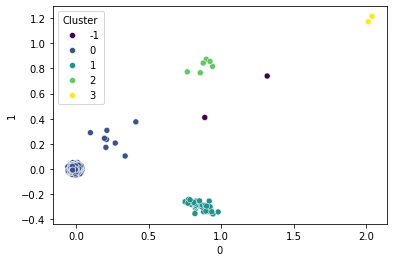

In [33]:
embeddings_df = pd.DataFrame(lyric_embeddings)

pca = PCA(n_components=2)
pca_embeddings = pd.DataFrame(pca.fit_transform(embeddings_df))

dbscan = DBSCAN(eps=0.3, min_samples=2)
clusters = dbscan.fit_predict(pca_embeddings)

pca_embeddings['Cluster'] = clusters

sns.scatterplot(x=pca_embeddings[0], y=pca_embeddings[1], hue=pca_embeddings['Cluster'], palette='viridis')


### r)
Show lyrics from the original `swift_df` dataframe contained in two distinct clusters using the two cells below. Answer separately, whether you consider the lyrics in each cluster to be similar or dissimilar.

_Note: You do not have to find exactly two clusters. Having at least two clusters, you should show the lyrics from two distinct clusters._ 

In [35]:
proc_indices = swift_df_proc.index
filtered_swift_df = swift_df.loc[proc_indices]

filtered_swift_df['Cluster'] = clusters

print("Lyrics from Cluster 1:")
print(filtered_swift_df[filtered_swift_df['Cluster'] == 1]['lyric'].head())

# print(clusters)

Lyrics from Cluster 1:
364      And our daddies used to joke about the two of us
889     'Cause none of us thought it was gonna end tha...
906     And nothin' we say is gonna save us from the f...
1161    These walls that they put up to hold us back w...
1163                                For us to finally win
Name: lyric, dtype: object


In [36]:
# Lyrics contained in one cluster
print("\nLyrics from Cluster 2:")
print(filtered_swift_df[filtered_swift_df['Cluster'] == 2]['lyric'].head())


Lyrics from Cluster 2:
912     It's 2 A.M., feeling like I just lost a friend
1808                And I remember that fight, 2:30 AM
2447                  Lit through the darkness at 1:58
3548                              4 AM, the second day
4179                              It's 2 AM in my room
Name: lyric, dtype: object


__Student Answer:__ Within cluster 1, one could argue that there are similarities with a few outliers - sentence length, informality and similar. For cluster 2, however, given lyrics seem to contain a number.

## An N-Gram Based Language Model (4 Pts)

In this subtask, we use the `swift_df` data to create an n-gram based language model to generate new lyrics. Therefore, we play around with different values for n.

### s)
Write the `lyric_preprocessor` method that takes a lyric as input and that tokenizes it and makes each word lowercase.

In [38]:
def lyric_preprocessor(lyric: str) -> [str]:
    """
    Tokenizes a lyric and makes the tokens lowercase.
    :param lyric: A string containing an input lyric.
    :return: A list containing lowercase tokens of the input lyric.
    """    
    tokens = nltk.word_tokenize(lyric)
    processed_lyric = [word.lower() for word in tokens]
    
    return processed_lyric



### t)
Apply the lyric_preprocessor to all lyrics in the `swift_df` and store the data in a `lyric_corpus` variable.

In [39]:
lyric_corpus = [lyric_preprocessor(lyric) for lyric in swift_df['lyric']]
lyric_corpus[:5]

[['he', 'said', 'the', 'way', 'my', 'blue', 'eyes', 'shined'],
 ['put', 'those', 'georgia', 'stars', 'to', 'shame', 'that', 'night'],
 ['i', 'said', ',', '``', 'that', "'s", 'a', 'lie', "''"],
 ['just', 'a', 'boy', 'in', 'a', 'chevy', 'truck'],
 ['that', 'had', 'a', 'tendency', 'of', 'gettin', "'", 'stuck']]

Next, train two n-grams with $n \in \{2,5\}$ on the lyric_corpus.

In [40]:
ngram_models = {}  # Dictionary to store trained n-gram models


n = 2
train_data, padded_vocab = padded_everygram_pipeline(n, lyric_corpus)
ngram_models[n] = MLE(n)  
ngram_models[n].fit(train_data, padded_vocab)

In [41]:
n = 5
train_data, padded_vocab = padded_everygram_pipeline(n, lyric_corpus)
ngram_models[n] = MLE(n)
ngram_models[n].fit(train_data, padded_vocab)

### u)
i. Write the `generate_lyrics` method that takes an n-gram model and an integer for the number of lyrics to be generated as input and that returns a list of new lyrics that were generated using the given n-gram model.

_Reminder / Hints: A lyric generated by an n-gram starts with n-1 times the start token "\<s>" and ends with n-1 times the end token "\</s>". Further, the n value of an n-gram can be accessed using the `n-gram.order` variable of an `n-gram`. Additionally keep in mind that you can condition the generation of your n-gram on some preceding text._

In [43]:
def generate_lyrics(n_gram_model, numb_of_new_lyrics: int) -> [str]:
    """
    Uses an n-gram model to generate several new lyrics.
    :param n_gram_model: An n-gram model. 
    :param numb_of_new_lyrics: The number of lyrics to be created.
    :return: As many generated lyrics as defined by the numb_of_new_lyrics.
    """
    generated_lyrics = []
    for _ in range(numb_of_new_lyrics):
        generated_lyric = []
        context = [n_gram_model.vocab.lookup('<s>')] * (n_gram_model.order - 1)  # initialize context with start tokens
        
        while True:
            token = n_gram_model.generate(text_seed=context[-(n_gram_model.order - 1):])
            if token == n_gram_model.vocab.lookup('</s>'):  # stop if end token
                break
            generated_lyric.append(token)
            context.append(token)
        
        generated_lyrics.append(' '.join(n_gram_model.vocab.lookup(token) for token in generated_lyric))
    
    return generated_lyrics


ii. Generate with the first and the second model ten lyrics each. Name one difference that you can find between the lyrics generated with 2-gram model and with the 5-gram model.

In [44]:
# first model
num_lyrics_to_generate = 10
generated_lyrics_2gram = generate_lyrics(ngram_models[2], num_lyrics_to_generate)
for idx, lyric in enumerate(generated_lyrics_2gram):
    print(f"Lyric {idx + 1}: {lyric}\n")


Lyric 1: you my beers and now i 'm on to me a fragile line that you 're ever lets me off around

Lyric 2: you could cry

Lyric 3: ask me , yeah

Lyric 4: and bone crush

Lyric 5: and

Lyric 6: i 'm breaking down

Lyric 7: yeah

Lyric 8: it

Lyric 9: is in a paint the back , that 's got there 's favorite song in the water

Lyric 10: but we are watching you to do n't have



In [45]:
# second model
generated_lyrics_5gram = generate_lyrics(ngram_models[5], num_lyrics_to_generate)
for idx, lyric in enumerate(generated_lyrics_5gram):
    print(f"Lyric {idx + 1}: {lyric}\n")

Lyric 1: until i see you again

Lyric 2: so light me up light me up

Lyric 3: there is happiness

Lyric 4: i can hear them whisper as we pass by

Lyric 5: you kiss on sidewalks

Lyric 6: that will find you the right thing

Lyric 7: drew looks at me

Lyric 8: laughing , when i 'm crying

Lyric 9: so i start a fight 'cause i need to feel something

Lyric 10: and now you 've got me alone , and i say



__Student Answer:__ The lyrics generated with our 2-gram model seems to be shorter and more fragmented. They exhibit a simpler structure and in some cases lack coherence. As for the 5-gram model, it is the opposite - they exhibit more detailed phrases as well as a smoother flow.  